In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import neighbors
from sklearn.model_selection import cross_val_score

import warnings
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Loading dataset
df_raw = pd.read_csv('datafiles/table_8_offenses_known_to_law_enforcement_california_by_city_2013.csv',
                     encoding='iso-8859-1')

In [3]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Adelanto,"31,165",198,2,NaN,15,52,129,886,381,372,133,17
1,Agoura Hills,"20,762",19,0,NaN,2,10,7,306,109,185,12,7
2,Alameda,"76,206",158,0,NaN,10,85,63,"1,902",287,"1,285",330,17
3,Albany,"19,104",29,0,NaN,1,24,4,557,94,388,75,7
4,Alhambra,"84,710",163,1,NaN,9,81,72,"1,774",344,"1,196",234,7


In [4]:
# Renaming columns
df_raw.columns = ['City','Population','Violent_Crime','Murder','Rape_a','Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 13 columns):
City              462 non-null object
Population        462 non-null object
Violent_Crime     462 non-null object
Murder            462 non-null int64
Rape_a            0 non-null float64
Rape_b            462 non-null int64
Robbery           462 non-null object
Assault           462 non-null object
Property_crime    462 non-null object
Burglary          462 non-null object
Larceny_theft     462 non-null object
Auto_theft        462 non-null object
Arson             462 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 47.0+ KB


## Generating dataset for analysis

In [6]:
# Dropping the revised rape definition column because it contains no info.
df1 = df_raw.drop(['Rape_a'], axis=1)

In [7]:
#Changing non-null object columns to ints for analysis

int_cols = ['Population','Violent_Crime','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# For column that has data stored as a string instead of a number, remove the comma,= and convert it to a number.
for x in int_cols:
    df1[x] = df_raw[x].str.replace(",","")
    df1[x] = pd.to_numeric(df1[x])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 12 columns):
City              462 non-null object
Population        462 non-null int64
Violent_Crime     462 non-null int64
Murder            462 non-null int64
Rape_b            462 non-null int64
Robbery           462 non-null int64
Assault           462 non-null int64
Property_crime    462 non-null int64
Burglary          462 non-null int64
Larceny_theft     462 non-null int64
Auto_theft        462 non-null int64
Arson             462 non-null int64
dtypes: int64(11), object(1)
memory usage: 43.4+ KB


In [9]:
df1[df1['Population'] > 800000]

,City,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson
234,Los Angeles,3878725,16524,251,764,7885,7624,85844,15728,55734,14382,1430
353,San Diego,1349306,5303,39,316,1456,3492,31728,6355,19230,6143,178
356,San Francisco,833863,7064,48,161,4202,2653,48324,5931,36527,5866,227
360,San Jose,992143,3215,38,270,1095,1812,25510,5173,12411,7926,133


In [10]:
# For simplicity sake, only looking at cities with a population under 800,000
df1 = df1.drop([234,353,282,356,360])

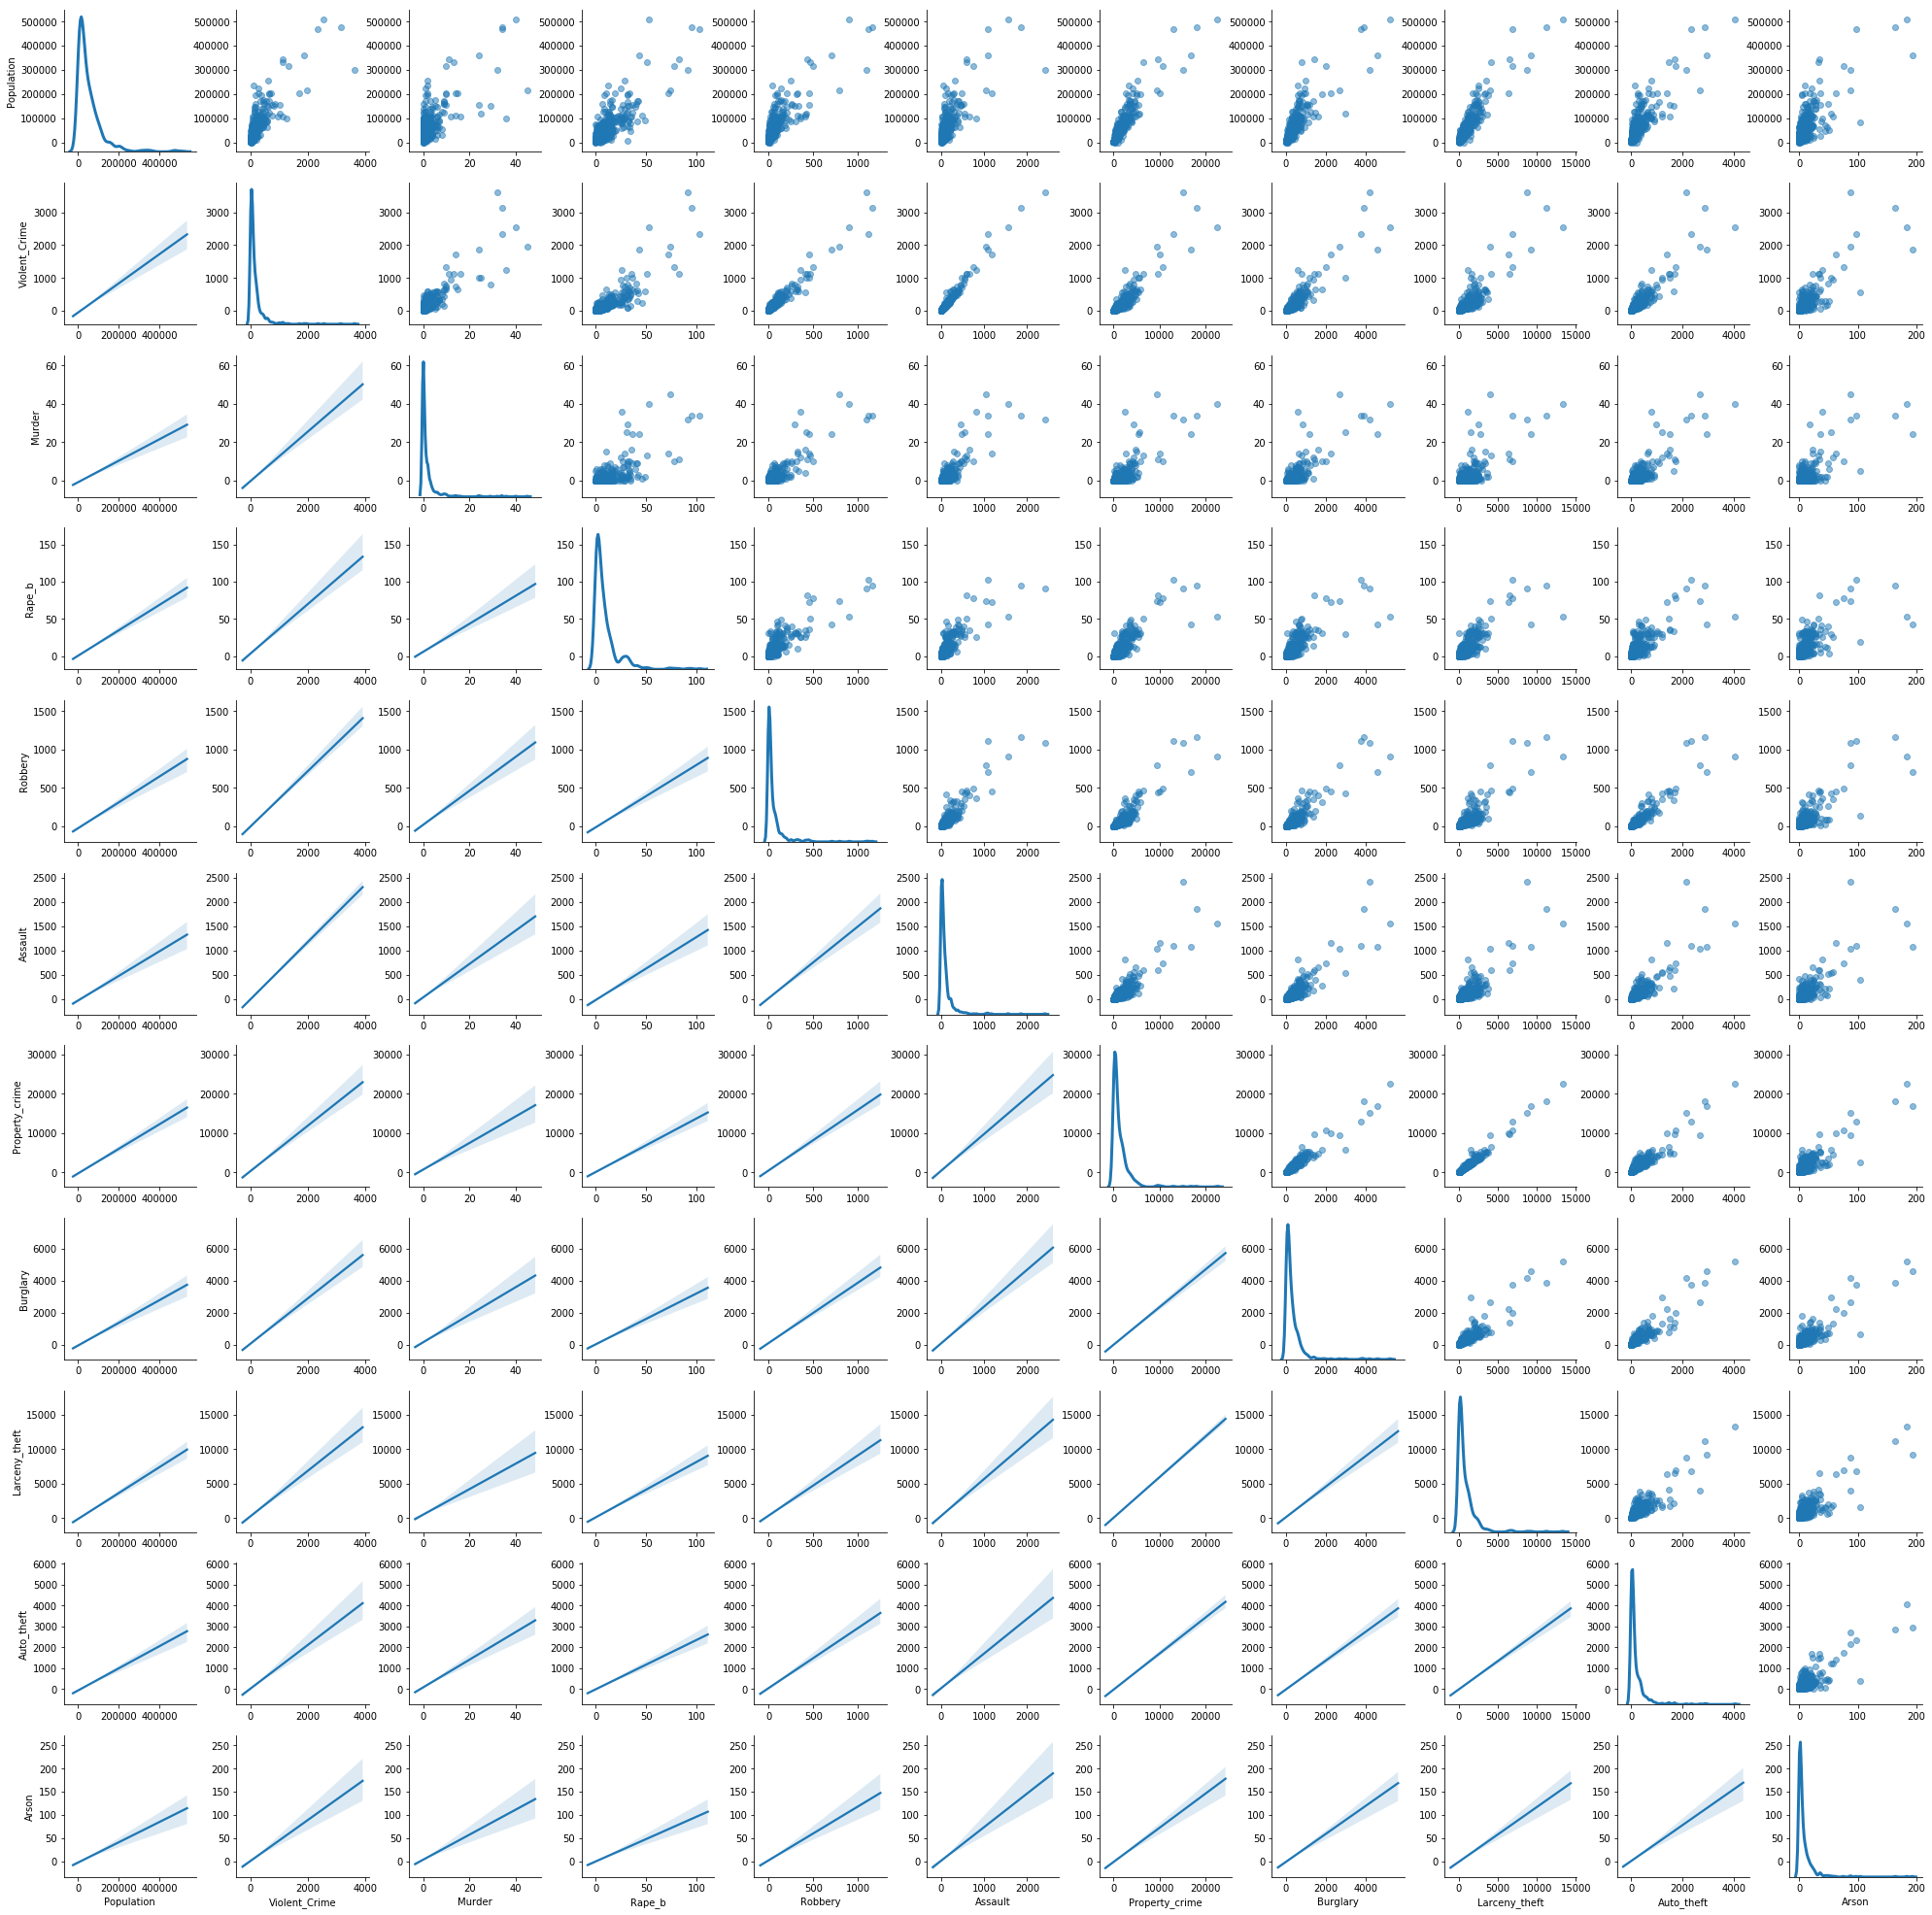

In [11]:
df_explore = df1.loc[:, 'Population':'Arson'].dropna()

# Scatterplot matrix
g = sns.PairGrid(df_explore, diag_sharey=False)

#Scatterplots
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing linear relationship of two variables
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Univariate distribtuion of the variables
g.map_diag(sns.kdeplot, lw=3)

plt.show()

Looking at Property crime, its relationship between the other features look linear for the most part.  THis satisfied the linear regression model's assumption of linear relationship.

# OLS Model

Let's create on OLS model that best predicts for property crime.

In [12]:
y = df1.Property_crime.values.reshape(-1, 1)
# What does values.reshape do?

X = df1.loc[:,'Population':'Arson']

## Testing assumptions

In [13]:
# Testing for the assumption of low collinearity

correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson
Population,1.000000,0.822193,0.701649,0.818725,0.837152,0.782009,0.918105,0.849320,0.922880,0.847659,0.753678
Violent_Crime,0.822193,1.000000,0.876777,0.864673,0.971696,0.987987,0.920197,0.919863,0.879265,0.907036,0.824801
Murder,0.701649,0.876777,1.000000,0.719348,0.877721,0.846981,0.792194,0.822767,0.724573,0.845260,0.741627
Rape_b,0.818725,0.864673,0.719348,1.000000,0.844441,0.836320,0.836054,0.796777,0.825426,0.789536,0.694522
Robbery,0.837152,0.971696,0.877721,0.844441,1.000000,0.924330,0.918658,0.916160,0.870584,0.931935,0.810811
Assault,0.782009,0.987987,0.846981,0.836320,0.924330,1.000000,0.891624,0.894402,0.855543,0.863047,0.809810
Property_crime,0.918105,0.920197,0.792194,0.836054,0.918658,0.891624,1.000000,0.960019,0.985599,0.940520,0.864735
Burglary,0.849320,0.919863,0.822767,0.796777,0.916160,0.894402,0.960019,1.000000,0.908476,0.921216,0.867279
Larceny_theft,0.922880,0.879265,0.724573,0.825426,0.870584,0.855543,0.985599,0.908476,1.000000,0.884099,0.831374
Auto_theft,0.847659,0.907036,0.845260,0.789536,0.931935,0.863047,0.940520,0.921216,0.884099,1.000000,0.831895


Hmm the collinearity is actually pretty high across the board, which is not surprising.  More of one type of crime is probably a good predictor of more crime in general.

We can use PLSR to pick the three features that are the best predictors for property crime.

## Fit the OLS model - Using sklearn

In [14]:
# Fit a linear model with all 10 features.
regr = linear_model.LinearRegression()
regr.fit(X, y)

# Save predicted values.
Y_pred = regr.predict(X)
print('R-squared regression:', regr.score(X, y))

# Print results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)

R-squared regression: 1.0

Coefficients: 
 [[  1.17961196e-16  -7.49400542e-16   5.80856486e-15  -6.90940360e-15
    4.16333634e-16   1.57859836e-16   7.50000000e-01   2.50000000e-01
    2.50000000e-01   2.50000000e-01  -7.88431820e-16]]

Intercept: 
 [ -6.82121026e-12]


A very high $R^2$.  This is a good indication that the model is grossly overfitted.  

In [15]:
# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(X, y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, y))

# Print results
print('\nCoefficients: \n', pls1.coef_)

R-squared PLSR: 0.998173848583

Coefficients: 
 [[ 172.02046907]
 [  32.96587495]
 [ -59.61967196]
 [-125.17122135]
 [  40.15952093]
 [  39.6042548 ]
 [ 611.85162911]
 [ 440.09053565]
 [ 734.2451737 ]
 [ 344.29773495]
 [  53.23658772]]


Still a high $R^2$.  ***What to do now?*** 

It doesn't look like PLSR picked 3 components... 11 coefficients are displayed.  What does components mean???

## Testing assumptions

#### Multivariate normality

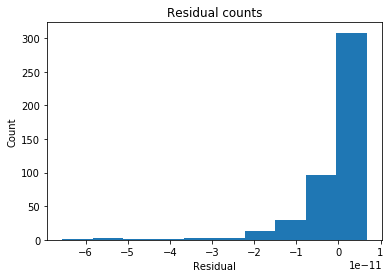

In [34]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df1.Property_crime

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Wow the residuals are real tiny.

### Homoscedasticity

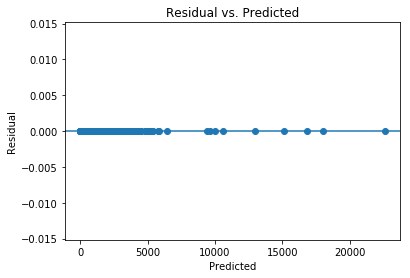

In [37]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

I built a super model? 

# Testing model on NY 2013 crime data

In [78]:
# Loading dataset
df_ny = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv')

# Removing info columns at head and tail of dataframe
df_ny = df_ny[4:352]

# Renaming columns
df_ny.columns = ['City','Population','Violent_Crime','Murder','Rape_a','Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# Resetting index
df_ny.reset_index(drop=True)

# Dropping the revised rape definition column because it contains no info.
df_ny = df_ny.drop(['Rape_a'], axis=1)

#Changing strings to ints for analysis

int_cols = ['Population','Violent_Crime','Murder', 'Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# For column that has data stored as a string instead of a number, remove '$', the comma, and convert it to a number.
for x in int_cols:
    df_ny[x] = df_ny[x].str.replace(",","")
    df_ny[x] = pd.to_numeric(df_ny[x])
    
# For consistency, dropping cities with populations over 800,000.
df_ny = df_ny.drop(df_ny[df_ny.Population > 800000].index)

df_ny = df_ny.dropna()

df_ny = df_ny.reset_index(drop=True)

In [79]:
df_ny.head()

,City,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.0
3,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0.0
4,Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,3.0


In [80]:
# Setting up X and Ys
X_ny = df_ny.loc[:,'Population':'Arson']
y_ny = df_ny.Property_crime.values.reshape(-1,1)

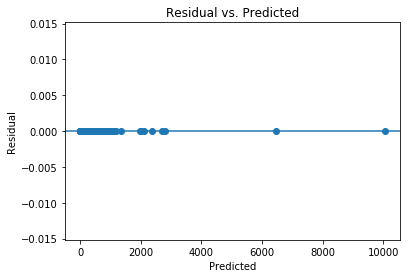

In [82]:
# Test model on New York data.
test_pred = regr.predict(X_ny).ravel()
actual = df_ny['Property_crime']

# Calculate the error, also called the residual.
residual = actual - test_pred

# Generating residuals and predicted scatterplot
plt.scatter(test_pred, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

I guess I built a super model.

![alt test](tyra.jpg)

## Fit OLS model - Using statmodels

In [16]:
# Using statmodels ols function so we can look at t-statistics and p-values.

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form

# Starting with all the features.
linear_formula = 'Property_crime ~ Population + Violent_Crime + Robbery + Assault + Murder + Rape_b + Burglary + Larceny_theft + Auto_theft + Arson'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df1).fit()

In [17]:
lm.params

Intercept       -7.680341e-13
Population       3.721652e-16
Violent_Crime   -2.831502e-14
Robbery          3.601630e-14
Assault          4.043592e-14
Murder          -1.142385e-13
Rape_b          -1.082299e-14
Burglary         1.000000e+00
Larceny_theft    1.000000e+00
Auto_theft       1.000000e+00
Arson            2.152732e-14
dtype: float64

The coefficents are different than the results from sklearn... shouldn't they be the same???

Also, what does the parameter of 1 mean?

In [18]:
lm.pvalues

Intercept        6.920392e-01
Population       1.046617e-09
Violent_Crime    8.234580e-01
Robbery          8.027133e-01
Assault          7.648010e-01
Murder           8.152891e-01
Rape_b           9.584574e-01
Burglary         0.000000e+00
Larceny_theft    0.000000e+00
Auto_theft       0.000000e+00
Arson            8.881277e-01
dtype: float64

Only population, burglary, larceny_theft, and auto_theft are significant. Actually, what does a pvalue of 0.000000e+00 mean? I assume that means it is highly significant.

In [19]:
lm.rsquared

1.0

$R^2$ of 1 signifies overfitting.

In [20]:
lm.conf_int()

,0,1
Intercept,-4.576341e-12,3.040273e-12
Population,2.548590e-16,4.894714e-16
Violent_Crime,-2.775957e-13,2.209657e-13
Robbery,-2.471292e-13,3.191618e-13
Assault,-2.250200e-13,3.058918e-13
Murder,-1.074730e-12,8.462531e-13
Rape_b,-4.189354e-13,3.972894e-13
Burglary,1.000000e+00,1.000000e+00
Larceny_theft,1.000000e+00,1.000000e+00
Auto_theft,1.000000e+00,1.000000e+00


Almost all variables have confidence intervals that contain zero...
What does a confidence interval of 1 to 1 mean?  Is that good?  Those are the only ones beside population that doesn't contain zero... Is there some error in the data?

In [21]:
# Removing variables with weak p values
linear_formula2 = 'Property_crime ~ Population + Burglary + Larceny_theft + Auto_theft'

# Fit the model
lm2 = smf.ols(formula=linear_formula2, data=df1).fit()

In [22]:
lm2.params

Intercept       -5.593009e-13
Population       3.141616e-17
Burglary         1.000000e+00
Larceny_theft    1.000000e+00
Auto_theft       1.000000e+00
dtype: float64

In [23]:
lm2.pvalues

Intercept        7.575290e-09
Population       6.397494e-25
Burglary         0.000000e+00
Larceny_theft    0.000000e+00
Auto_theft       0.000000e+00
dtype: float64

In [24]:
lm2.rsquared

1.0

In [25]:
lm2.conf_int()

,0,1
Intercept,-7.459353e-13,-3.726665e-13
Population,2.577922e-17,3.705310e-17
Burglary,1.000000e+00,1.000000e+00
Larceny_theft,1.000000e+00,1.000000e+00
Auto_theft,1.000000e+00,1.000000e+00


Is this a really amazing model, or did I do something wrong? Scrolling up to the plot matrix, the relationship between property crime and burglary, larceny theft, and auto theft do look to be a one to one relationship... 

## Building KNN Regression - using sklearn

### Unweighted

In [26]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [27]:
score = cross_val_score(knn, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.79 (+/- 0.11)


In [28]:
score

array([ 0.86831781,  0.72145456,  0.83613157,  0.79175405,  0.73899034])

### Weighted

In [29]:
# Using weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [30]:
score = cross_val_score(knn_w, X, y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Weighted Accuracy: 0.83 (+/- 0.08)


In [31]:
score

array([ 0.86537797,  0.81896909,  0.81939409,  0.87639252,  0.76692268])

The mean accuracy of the weighted scores from cross validation is better.

# Conclusion

I mean, you can't really beat an $R^2$ of 1, can you?  Comparing the $R^2$ for OLS and KNN, OLS regression definitely did better.  

A KNN regression is a non-parametric modelling method, and thus more of a "black box". It does not assume a linear relationship, for example. KNN is better at considering local effects in the dataset. However, KNN is often more complex to understand and interpret.
OLS is a parametric modelling method.  We can use the coefficents of the parameters to consider the impact that the dependent variables have on the independent variable.  